In [1]:
library(magrittr)
library(GenomicRanges)
library(DESeq2)
library(chromVAR)

# library(BiocParallel)
# register(MulticoreParam(8)) # Use 8 cores

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The follow

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'DESeq2'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'GenomeInfoDb', 'IRanges', 'S4Vectors', 'crayon'



In [3]:
BiocManager::install("chromVAR")

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'chromVAR'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'GenomeInfoDb', 'IRanges', 'S4Vectors', 'crayon'



In [4]:
mPeak = GRanges()

peakRes = read.table("/Users/cheshic/dev/repos/cutandrun/results/seacr/h3k4me3_R1.bed.stringent.bed", header = FALSE, fill = TRUE)
mPeak = GRanges(seqnames = peakRes$V1, IRanges(start = peakRes$V2, end = peakRes$V3), strand = "*") %>% append(mPeak, .)

peakRes = read.table("/Users/cheshic/dev/repos/cutandrun/results/seacr/h3k4me3_R2.bed.stringent.bed", header = FALSE, fill = TRUE)
mPeak = GRanges(seqnames = peakRes$V1, IRanges(start = peakRes$V2, end = peakRes$V3), strand = "*") %>% append(mPeak, .)

peakRes = read.table("/Users/cheshic/dev/repos/cutandrun/results/seacr/h3k27me3_R1.bed.stringent.bed", header = FALSE, fill = TRUE)
mPeak = GRanges(seqnames = peakRes$V1, IRanges(start = peakRes$V2, end = peakRes$V3), strand = "*") %>% append(mPeak, .)

peakRes = read.table("/Users/cheshic/dev/repos/cutandrun/results/seacr/h3k27me3_R2.bed.stringent.bed", header = FALSE, fill = TRUE)
mPeak = GRanges(seqnames = peakRes$V1, IRanges(start = peakRes$V2, end = peakRes$V3), strand = "*") %>% append(mPeak, .)

masterPeak = reduce(mPeak)

In [5]:
countMat = matrix(NA, length(masterPeak), 4)

fragment_counts <- getCounts("/Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k4me3_R1.markdup.bam", masterPeak, paired = TRUE, by_rg = FALSE, format = "bam")
countMat[, 1] = counts(fragment_counts)[,1]

fragment_counts <- getCounts("/Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k4me3_R2.markdup.bam", masterPeak, paired = TRUE, by_rg = FALSE, format = "bam")
countMat[, 2] = counts(fragment_counts)[,1]

fragment_counts <- getCounts("/Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k27me3_R1.markdup.bam", masterPeak, paired = TRUE, by_rg = FALSE, format = "bam")
countMat[, 3] = counts(fragment_counts)[,1]

fragment_counts <- getCounts("/Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k27me3_R2.markdup.bam", masterPeak, paired = TRUE, by_rg = FALSE, format = "bam")
countMat[, 4] = counts(fragment_counts)[,1]

histL = c("K27me3", "K4me3")
repL = paste0("rep", 1:2)
colnames(countMat) = paste(rep(histL, 2), rep(repL, each = 2), sep = "_")

Reading in file: /Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k4me3_R1.markdup.bam

Reading in file: /Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k4me3_R2.markdup.bam

Reading in file: /Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k27me3_R1.markdup.bam

Reading in file: /Users/cheshic/dev/repos/cutandrun/results/bowtie2/target/picard_markdup/h3k27me3_R2.markdup.bam



In [7]:
selectR = which(rowSums(countMat) > 5) ## remove low count genes
dataS = countMat[selectR,]
condition = factor(rep(histL, each = length(repL)))

dds = DESeqDataSetFromMatrix(countData = dataS,
                              colData = DataFrame(condition),
                              design = ~ condition)
DDS = DESeq(dds)
normDDS = counts(DDS, normalized = TRUE) ## normalization with respect to the sequencing depth
colnames(normDDS) = paste0(colnames(normDDS), "_norm")
res = results(DDS, independentFiltering = FALSE, altHypothesis = "greaterAbs")

countMatDiff = cbind(dataS, normDDS, res)
head(countMatDiff)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



DataFrame with 6 rows and 14 columns
  K27me3_rep1 K4me3_rep1 K27me3_rep2 K4me3_rep2 K27me3_rep1_norm
    <numeric>  <numeric>   <numeric>  <numeric>        <numeric>
1         157        204          43         98        263.00396
2           0          1           2          3          0.00000
3           0          1           3          2          0.00000
4           0          0           3          3          0.00000
5          16         15           5         17         26.80295
6           1          2           1          3          1.67518
  K4me3_rep1_norm K27me3_rep2_norm K4me3_rep2_norm   baseMean log2FoldChange
        <numeric>        <numeric>       <numeric>  <numeric>      <numeric>
1       305.05115        26.677339        62.92038 164.413208      -2.665518
2         1.49535         1.240806         1.92613   1.165572       1.019385
3         1.49535         1.861210         1.28409   1.160162       1.010569
4         0.00000         1.861210         1.92613   0.946

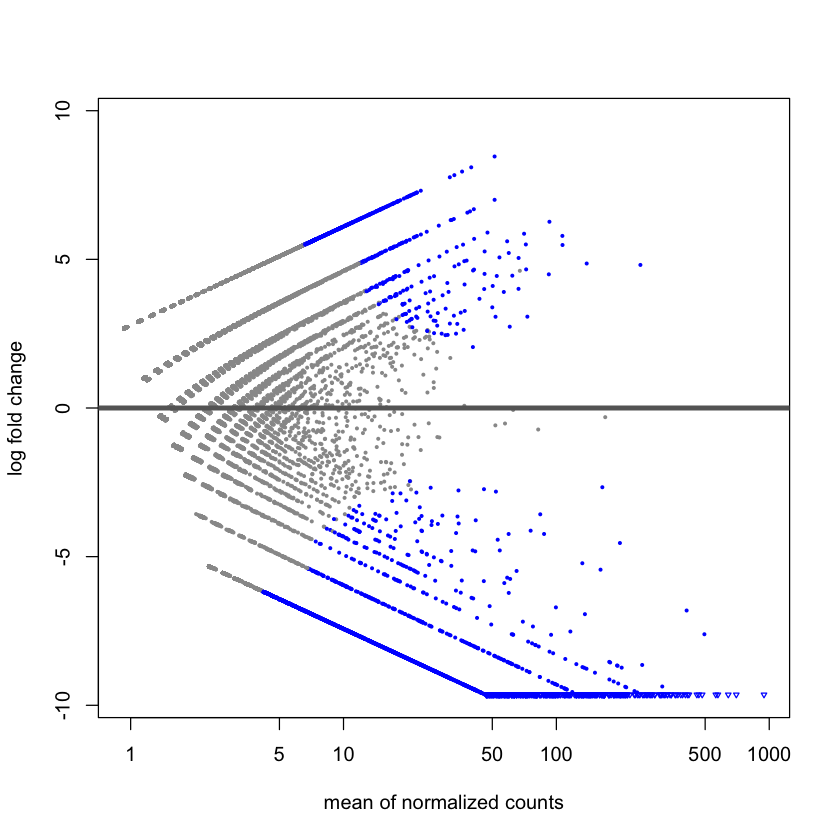

In [12]:
plotMA(res)

In [13]:
resultsNames(dds)

character(0)

In [15]:
resOrdered <- res[order(res$pvalue),]

In [17]:
summary(res)

write.csv(as.data.frame(resOrdered), file="results.csv")


out of 55516 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 602, 1.1%
LFC < 0 (down)     : 2361, 4.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

